# | P7 - Détection de Bad Buzz via du Deep Learning

<img src="https://user.oc-static.com/upload/2019/10/22/15717382019055_Capture%20d%E2%80%99e%CC%81cran%202019-10-22%20a%CC%80%2011.50.29.png">


# API sur étagère avec le service cognitif de Microsoft Azure

Dans cette partie, nous observerons les prédictions de sentiment provenant du service cognitif de Microsoft Azure.

<b> Le service de Microsoft Azure </b>

<img src="utile/detectiondesentiment.jpg">

Microsoft Azure nous donne accès à son modèle de prédiction de sentiment via une clé et un point de terminaison qui servent à authentifier l'utilisateur voulant accéder au service.

Le service est gratuit en dessous de la limite de 5 000 enregistrements de texte par mois, puis connaît une tarification progressive.

Le modèle offre en sortie une prédiction gaussienne sur trois variables : Positif, Neutre, Négatif.
Pour chaque tweet, nous obtenons ainsi un vecteur de nombre réel de dimensions 3.

Nous appliquerons ensuite une régression linéaire nous permettant de séparer nos données en deux classes : Positif et Négatif.

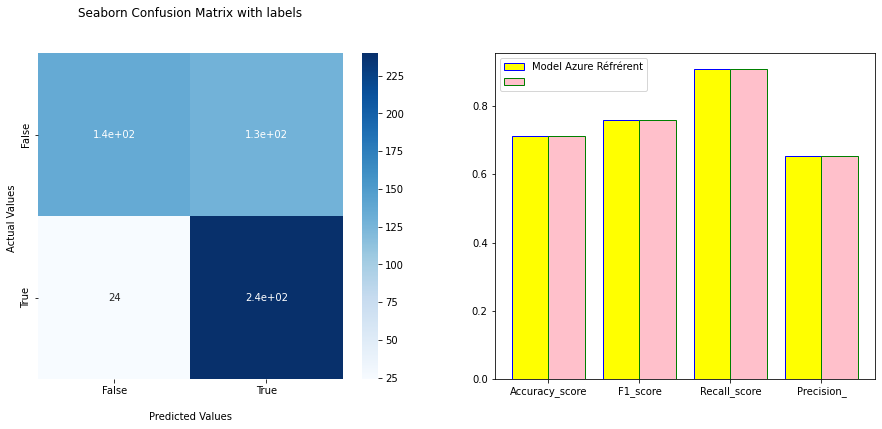

CPU times: user 48.6 s, sys: 8.53 s, total: 57.1 s
Wall time: 5min 34s


(0.7121212121212122, 0.759493670886076, 0.9090909090909091, 0.6521739130434783)

In [1]:
%%time
from functions import *
import warnings
warnings.filterwarnings('ignore')

now = datetime.now()
df_score = pd.DataFrame(columns=['Model', 
                                 'Accuracy_score', 
                                 'F1_score', 
                                 'Recall_score',
                                 'Precision_',
                                 'Learing_time',
                                ])

df_ = pd.read_csv('utile/data.csv')
Azure_pred = df_.text.apply(get_sentiment_from_Azure)
    
X = np.array([np.array(x) for x in Azure_pred])
y = df_.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

reg = SGDClassifier().fit(X_train, y_train)
y_pred = reg.predict(X_test)

time = [datetime.now() - now][0].total_seconds()
precision_ = precision_score(y_test, y_pred)
acc_ = accuracy_score(y_test, y_pred)
recall_ =recall_score(y_test, y_pred)
f1_ = f1_score(y_test, y_pred)

df_score.loc[0] = ['Model Azure Réfrérent',
                   acc_, 
                   f1_, 
                   recall_, 
                   precision_, 
                   time]
df_score.to_csv('utile/df_score.csv')

evaluate(y_test, y_pred)

[A compléter]

# Modèle sur mesure simple

L'outil concepteur du service Microsoft Azure permet de créer des modèles prédictifs par simple glissé/déposé.

Nous avons utilisé ce service pour créer un modèle de classification binaire qui traite la donnée en plusieurs étapes :
1. nous récupérons les données, soit en les importants directement dans l'outils soit via une API (key + endpoint),
2. nous sélectionnons nos features, seule la variable texte nous importe.
3. nous nettoyons le jeu de données (valeurs manquante, dupliquées...),
4. nous appliquons une transformation/tokenisation de nos données textes avec le module "Extract N-Gram Features from Text" (lemm+TFIDF).
5. nous appliquons le modèle "MultiClass Boosted Decision Tree" à nos données transformées.
6. nous récupérons à la fois la prédiction, mais également le résultat de la transformation de nos données textuelles.

<img src="utile/detectiondesentiment_azure.png">


Pour obtenir nos prédictions nous pouvons donc soit faire appel à l'API déployé, ce qui engendrera des coûts ainsi qu'un temps de chargement conséquent, soit importé directement nos données dans l'outil concepteur. C'est cette dernière option que nous avons suivi. Nous chargeons ensuite les résultats dans ce notebook afin d'observer et de mesurer nos résultats.

Par la suite, nous comparons la prédiction faite à partir du concepteur Azure à la prédiction d'un modèle entraîner à partir des données transformée par le concepteur.

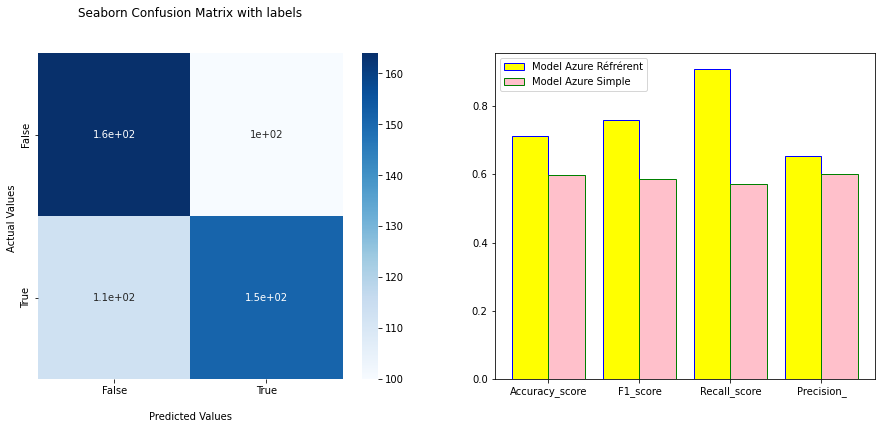

In [3]:
from sklearn.tree import DecisionTreeClassifier
import urllib.request
import json
import os

from datetime import datetime
now = datetime.now()


Azure_embeding = pd.read_csv("utile/data_result.csv").drop(['text','label','Preprocessed text',
                                     'Scored Probabilities_0', 'Scored Probabilities_1',
                                                            'Scored Labels'], axis=1)


endpoint = 'http://9d10c6a1-40f8-4b04-be6e-ad1640c50eea.francecentral.azurecontainer.io/score'
key = os.environ['Azure_model_simple']

# fonction de transformation des données en vue de l'utilisation de l'API
def input_data(x):
    # Prepare the input data
    data = {
        "Inputs": {
            "WebServiceInput0":
            [
                {
                    'label':None,
                    'text': x,
                },
            ],
        },
        "GlobalParameters":  {
        }
    }
    return data

# Prédiction après appel de l'API 
def prediction_(data):
    body = str.encode(json.dumps(data))
    headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ key)}
    req = urllib.request.Request(endpoint, body, headers)
    try:
        response = urllib.request.urlopen(req)
        result = response.read()
        json_result = json.loads(result)
        y = json_result["Results"]["WebServiceOutput0"][0]
        return y['predicted_label']

    except urllib.error.HTTPError as error:
        print("The request failed with status code: " + str(error.code))

        # Print the headers to help debug the error
        print(error.info())
        print(json.loads(error.read().decode("utf8", 'ignore')))
        


X = Azure_embeding.values
y = df_.label

# Prédiction de classe à partir d'un modèle DecisionTree
model = DecisionTreeClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc_, f1_, recall_, precision = evaluate(y_test, y_pred, 'Model Azure Simple')
time = [datetime.now() - now][0].total_seconds()
df_score.loc[1] = ['Model Azure Simple',acc_, f1_, recall_, precision_, time]
df_score.to_csv('utile/df_score.csv')

# Data préparation

## Prétratement de la donnée textuelle

In [1]:
%%time

import spacy
import pickle
from nltk.stem.snowball import SnowballStemmer

import pandas as pd
df_ = pd.read_csv('utile/data.csv')

stemmer = SnowballStemmer(language='english')
stemmer = stemmer.stem

# import de spacy
nlp = spacy.load("en_core_web_sm")

# transformation du text en minuscule
df_.text = df_.text.apply(lambda x: x.lower())

document = df_.text.apply(nlp)

# Lemmatization + Stemming
tokens = [[stemmer(u.lemma_) for u in doc if u.is_alpha or u.is_punct] for doc in document]


sentences = []
all_docs = ''
for ligne in tokens:
    text = ''
    for mot in ligne:
        text += mot + ' '
        all_docs += mot + ' '
    sentences.append(text)

df_['text_'] = sentences

# Sauvegard du traitement 
with open('./utile/document.txt', 'w') as f:
    for each_text in df_.text_:
        f.writelines(f'{each_text}\n')
        
print('initial : ',df_.text[2])
print(f'final : {df_.text_[2]}')
print()
print(f'Exemple de lemmization : {document[2][9]} --> {document[2][9].lemma_}')
print(f'Exemple de Stemming : {document[2][9]} --> {stemmer(document[2][9].text)}')

print()

initial :  @kenichan i dived many times for the ball. managed to save 50%  the rest go out of bounds
final : i dive mani time for the ball . manag to save % the rest go out of bound 

Exemple de lemmization : managed --> manage
Exemple de Stemming : managed --> manag

CPU times: user 16.1 s, sys: 2.12 s, total: 18.2 s
Wall time: 17 s


## WordEmbeding avec word2vec

Une fois le pré-traitement textuel achevé nous pouvons appliquer notre méthode de plongement de mot, ou Word Embedding, afin de transformer notre corpus de text en matrice de nombre réel.

<img src='https://user.oc-static.com/upload/2018/12/17/15450632262546_diabolo-1.png'>

L'approche word2vec repose sur l'architecture CBOW (Continuous Bag Of Words) qui vise à prédire un mot étant donné son contexte, c'est-à-dire étant donné les mots qui en sont proches dans le texte.

Nous obtenons ainsi pour chaque mot de notre corpus une projection vectorielle qui contiendra une information relative au contexte.

/var/folders/pd/d9xkkvws5r5f_x34lthx34ph0000gn/T/ipykernel_93607/1289113179.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  embeding_w2v = np.array([np.array(x) for x in embeding_w2v.values])
/Users/kevinduranty/miniforge3/envs/p7/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimensions dataset après réduction PCA :  (3287, 21)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


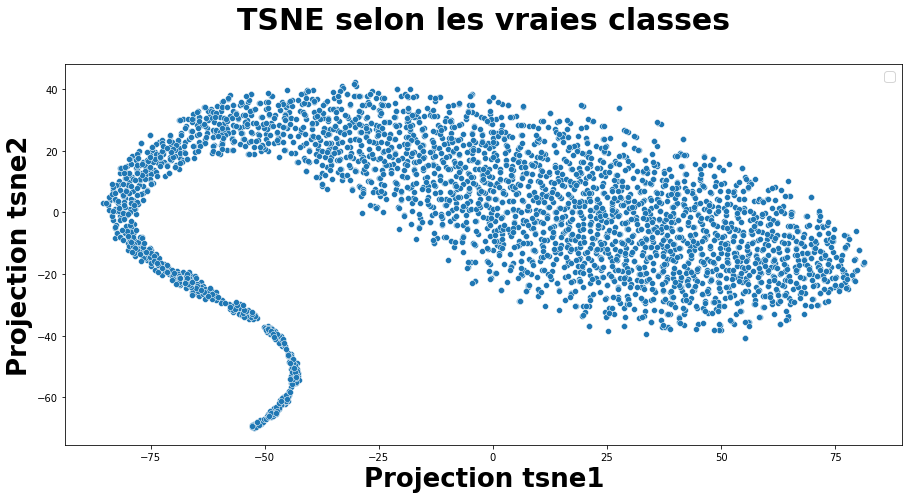

In [350]:
model = Word2Vec(sentences=tokens, vector_size=32, window=5, min_count=1, workers=4)

def get_w2v_embed(doc):
    return [model.wv[x] for x in doc.split()]

embeding_w2v = df_.text_.apply(get_w2v_embed)
embeding_w2v = np.array([np.array(x) for x in embeding_w2v.values])
embeding_w2v = padding(embeding_w2v,32,model.wv['.'])

X = [model.wv[x] for x in set(all_docs.split())]
show_tsne(X)

with open('utile/embeding_w2v', 'wb') as handle:
    pickle.dump(embeding_w2v,handle, protocol=pickle.HIGHEST_PROTOCOL)

## WordEmbeding avec Fasttext

<img src='https://fasttext.cc/img/fasttext-logo-color-web.png'>


FastText est une bibliothèque créée au sein du laboratoire AI Research de Facebook, ce modèle permet de créer un apprentissage non supervisé des représentations vectorielles des mots d'un corpus passés en entrée.

Le modèle nous permet soit d'avoir une représentation vectorielle de nos tokens, soit avoir une représentation de nos phrases.

Read 0M words
Number of words:  539
Number of labels: 0
Progress: 100.0% words/sec/thread:  133761 lr:  0.000000 avg.loss:  3.520550 ETA:   0h 0m 0s
/var/folders/pd/d9xkkvws5r5f_x34lthx34ph0000gn/T/ipykernel_93607/803266966.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  embeding_fasttext = np.array([np.array(x) for x in embeding_fasttext])
/Users/kevinduranty/miniforge3/envs/p7/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimensions dataset après réduction PCA :  (539, 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


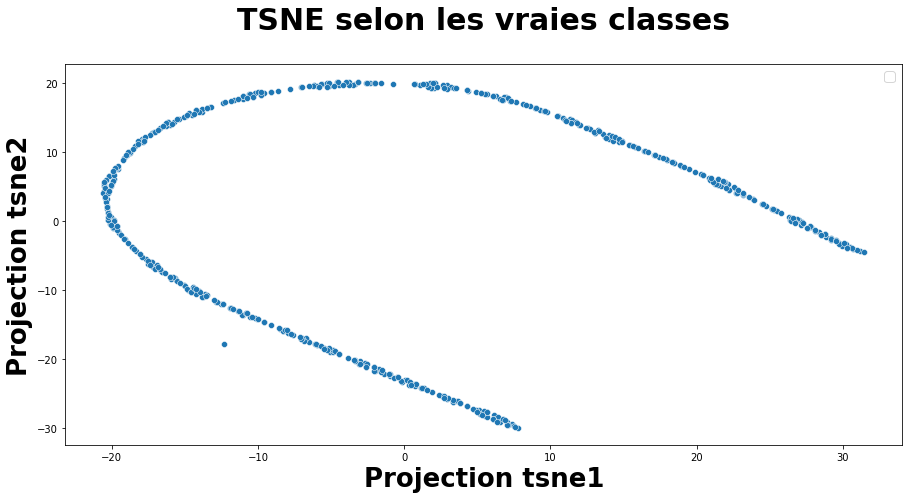

/Users/kevinduranty/miniforge3/envs/p7/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimensions dataset après réduction PCA :  (1600, 57)


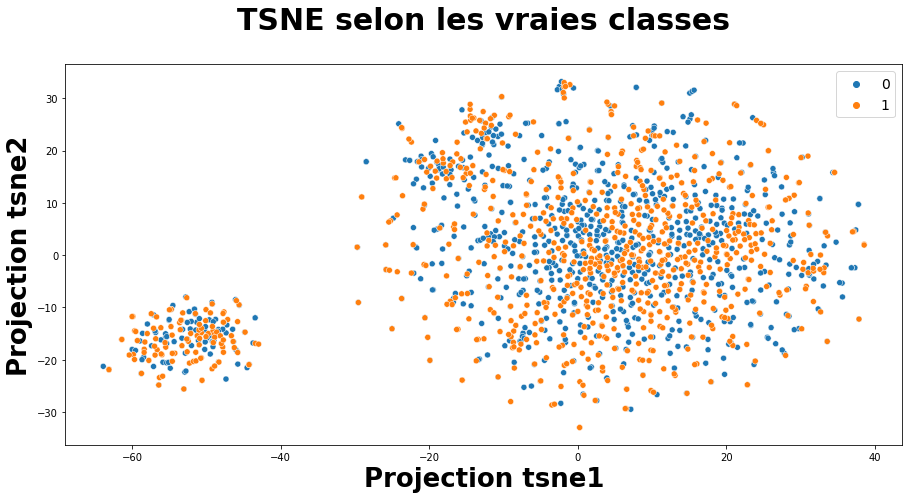

In [381]:
model = fasttext.train_unsupervised('utile/document.txt', "cbow")

def get_fasttext_sentence(doc):
    return model.get_sentence_vector(doc)

def get_fasttext_embed(doc):
    return [model.get_word_vector(x) for x in doc.split()]

embeding_fasttext = df_.text_.apply(get_fasttext_embed).values
embeding_fasttext = np.array([np.array(x) for x in embeding_fasttext])
embeding_fasttext = padding(embeding_fasttext, 100, model.get_word_vector('.'))

embeding_sentence = df_.text_.apply(get_fasttext_sentence).values

X = [model.get_word_vector(x) for x in model.get_words()]
show_tsne(X)

show_tsne(list(embeding_sentence),True)

with open('utile/embeding_fasttext', 'wb') as handle:
    pickle.dump(embeding_fasttext, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('utile/embeding_sentence', 'wb') as handle:
    pickle.dump(embeding_sentence, handle, protocol=pickle.HIGHEST_PROTOCOL)

Sur ce graphe, après projection sur un plan de la représentation de nos phrases transformées par fasttext, nous n'apercevons pas de séparation de nos données en fonction de leurs labels, ce qui nous montre qu'un algorithme de classification linéaire n'est pas adapter à notre problème.

Par la suite, nous développerons des modèles de classification binaire de deep learning créés à partir de la bibliothèque Keras et Tensorflow.